# Lab3 - AI - Convolutional Neural networks for image recognition

**R4.A.13 - BUT2 - IUT Vannes**


## Introduction

**Setting up the environment**


In [1]:
# Import required packages from Pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# fix random seed for reproducibility
import numpy as np
np.random.seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


##  CNNs for Cifar10 - training from scratch

Now let's build CNN models to work on the CIFAR10 dataset.

Try to reach the best performance on validation by designing other CNNs.

In [2]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43614449.28it/s]


Extracting DATA_CIFAR/cifar-10-python.tar.gz to DATA_CIFAR/
Files already downloaded and verified


In [3]:
# show the training size, test size, number of class
print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

Train size :  50000
validation size :  10000


In [4]:
# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

torch.Size([64, 3, 32, 32])
torch.Size([64])


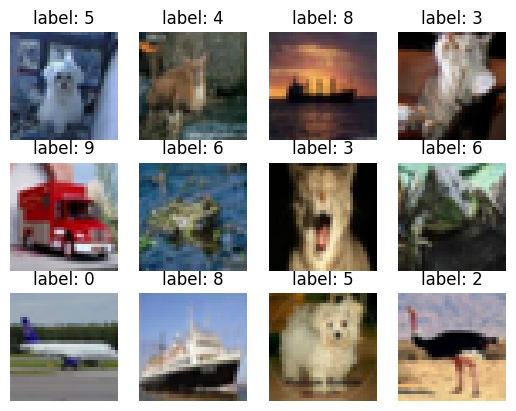

In [5]:
# Display some image samples using matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off') # (img/2+0.5) is just to unnormalize the image
    plt.title("label: " + str(labels[i].numpy().squeeze()))

In [6]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3,        # different from Mnist car ce sont les images couleur
            out_channels=32,
            kernel_size=5,
            stride=1,
            padding=2
        )
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # different from Mnist since the size of image is 32*32*3
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = CNN_cifar()
model.to(device)
# print number of total trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_trainable_params )

579402


In [8]:
optimizer = optim.SGD(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [9]:
import time

epochs = 25
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

start_time_scratch_train = time.time()

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0

    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(validation_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)


    print("Epoch: {}/{}  ".format(epoch, epochs),
          "Training loss: {:.4f}  ".format(total_train_loss),
          "Validation loss: {:.4f}  ".format(total_val_loss),
          "Train accuracy: {:.4f}  ".format(accuracy_train),
          "Validation accuracy: {:.4f}  ".format(accuracy_val))

end_time_scratch_train = time.time()
time_scratch_train = end_time_scratch_train - start_time_scratch_train
accuracy_scratch = accuracy_total_val[-1]*100
epochs_scratch = epochs


Epoch: 0/25   Training loss: 2.2471   Validation loss: 2.1350   Train accuracy: 0.1935   Validation accuracy: 0.2525  
Epoch: 1/25   Training loss: 2.0129   Validation loss: 1.8984   Train accuracy: 0.2894   Validation accuracy: 0.3291  
Epoch: 2/25   Training loss: 1.8363   Validation loss: 1.7640   Train accuracy: 0.3485   Validation accuracy: 0.3696  
Epoch: 3/25   Training loss: 1.7038   Validation loss: 1.6474   Train accuracy: 0.3948   Validation accuracy: 0.4142  
Epoch: 4/25   Training loss: 1.5941   Validation loss: 1.5445   Train accuracy: 0.4296   Validation accuracy: 0.4436  
Epoch: 5/25   Training loss: 1.5146   Validation loss: 1.4851   Train accuracy: 0.4577   Validation accuracy: 0.4579  
Epoch: 6/25   Training loss: 1.4545   Validation loss: 1.4296   Train accuracy: 0.4784   Validation accuracy: 0.4875  
Epoch: 7/25   Training loss: 1.4054   Validation loss: 1.4092   Train accuracy: 0.4972   Validation accuracy: 0.4956  
Epoch: 8/25   Training loss: 1.3674   Validation

Text(0.5, 1.0, 'Train and validation losses - Cifar10')

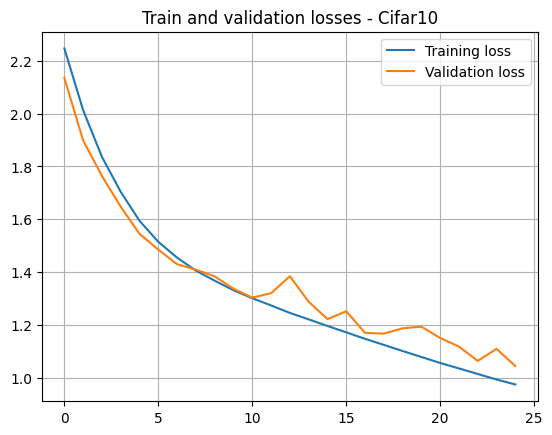

In [10]:
# plot the loss curves
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - Cifar10')

Text(0.5, 1.0, 'Train and validation accuracies - cifar10')

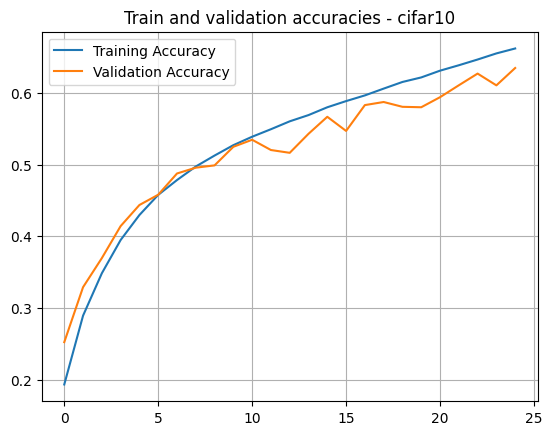

In [11]:
# plot the accuracy curves
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - cifar10')

## Transfer learning with pre-trained networks

In [12]:
import torch
from torchvision import datasets, transforms

# Define transform to normalize data

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


# CNNs for Cifar10 - training from CNN(1,2) (feat_extract, fine_tuning)

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from torchvision import models
import pandas as pd

# Préparation des Données CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Définir les classes CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Déplacer le modèle vers le GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 170498071/170498071 [00:03<00:00, 43735759.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_loss, val_loss = [], []
    accuracy_total_train, accuracy_total_val = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = running_corrects.double() / len(trainloader.dataset)

        train_loss.append(epoch_loss)
        accuracy_total_train.append(epoch_acc.cpu().item())

        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0

        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_val_corrects += torch.sum(preds == labels.data)

        val_loss.append(running_val_loss / len(testloader.dataset))
        accuracy_total_val.append(running_val_corrects.cpu().double() / len(testloader.dataset))

        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Val Loss: {val_loss[-1]:.4f} Val Acc: {accuracy_total_val[-1]:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model, time_elapsed, num_epochs, train_loss, val_loss, accuracy_total_train, accuracy_total_val


In [15]:
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    elapsed_time = time.time() - start_time
    print(f'Accuracy: {accuracy}%')
    print(f'Evaluation Time: {elapsed_time:.2f} seconds')
    return accuracy, elapsed_time

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 177MB/s]


Epoch 0/24 Loss: 1.5806 Acc: 0.4476 Val Loss: 1.2553 Val Acc: 0.5556
Epoch 1/24 Loss: 1.4656 Acc: 0.4842 Val Loss: 1.2287 Val Acc: 0.5645
Epoch 2/24 Loss: 1.4450 Acc: 0.4925 Val Loss: 1.2014 Val Acc: 0.5736
Epoch 3/24 Loss: 1.4303 Acc: 0.4980 Val Loss: 1.2363 Val Acc: 0.5637
Epoch 4/24 Loss: 1.4302 Acc: 0.5001 Val Loss: 1.1658 Val Acc: 0.5905
Epoch 5/24 Loss: 1.4218 Acc: 0.5033 Val Loss: 1.1993 Val Acc: 0.5735
Epoch 6/24 Loss: 1.4208 Acc: 0.4991 Val Loss: 1.1829 Val Acc: 0.5842
Epoch 7/24 Loss: 1.3705 Acc: 0.5115 Val Loss: 1.1572 Val Acc: 0.5916
Epoch 8/24 Loss: 1.3491 Acc: 0.5207 Val Loss: 1.1481 Val Acc: 0.5963
Epoch 9/24 Loss: 1.3412 Acc: 0.5217 Val Loss: 1.1473 Val Acc: 0.5969
Epoch 10/24 Loss: 1.3374 Acc: 0.5228 Val Loss: 1.1369 Val Acc: 0.5972
Epoch 11/24 Loss: 1.3230 Acc: 0.5294 Val Loss: 1.1373 Val Acc: 0.6003
Epoch 12/24 Loss: 1.3158 Acc: 0.5317 Val Loss: 1.1436 Val Acc: 0.5960
Epoch 13/24 Loss: 1.3123 Acc: 0.5291 Val Loss: 1.1382 Val Acc: 0.5989
Epoch 14/24 Loss: 1.3056 Acc: 

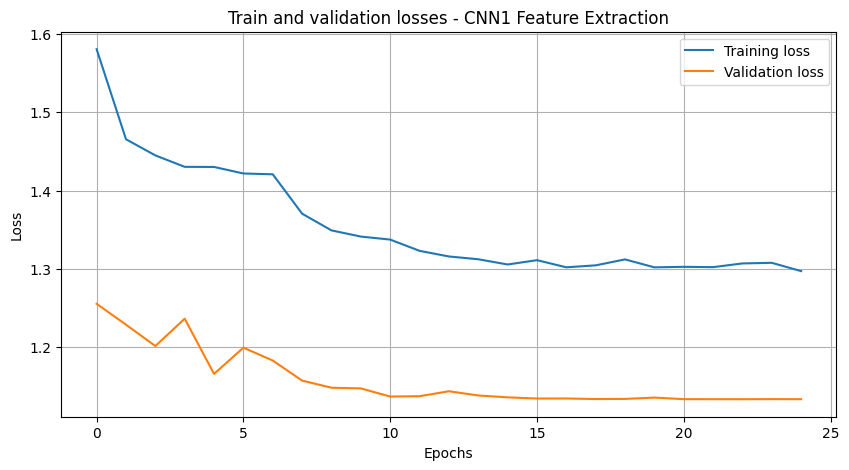

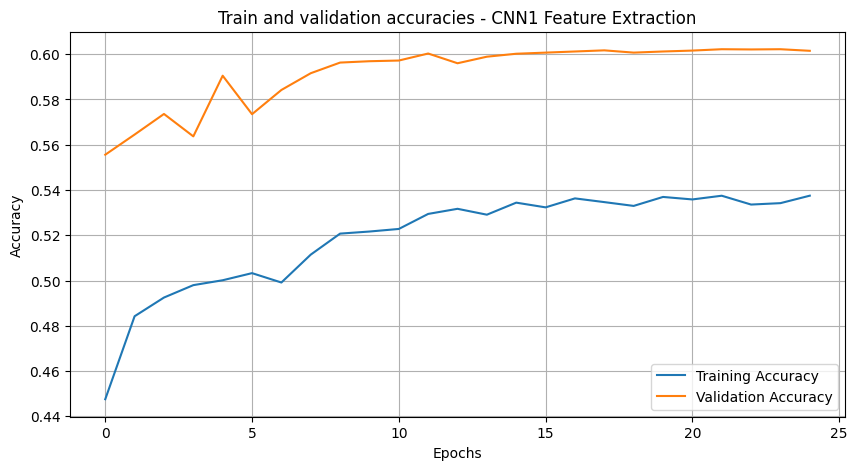

In [16]:
# 1. CNN1 Feature Extraction
model_vgg_feat = models.vgg16(pretrained=True)
for param in model_vgg_feat.parameters():
    param.requires_grad = False
model_vgg_feat.classifier[6] = nn.Linear(model_vgg_feat.classifier[6].in_features, 10)
model_vgg_feat = model_vgg_feat.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg_feat = optim.SGD(model_vgg_feat.classifier[6].parameters(), lr=0.001, momentum=0.9)
scheduler_vgg_feat = lr_scheduler.StepLR(optimizer_vgg_feat, step_size=7, gamma=0.1)

model_vgg_feat, time_vgg_feat_train, epochs_vgg_feat, train_loss_vgg_feat, val_loss_vgg_feat, accuracy_total_train_vgg_feat, accuracy_total_val_vgg_feat = train_model(model_vgg_feat, criterion, optimizer_vgg_feat, scheduler_vgg_feat, num_epochs=25)
accuracy_vgg_feat, time_vgg_feat_eval = evaluate_model(model_vgg_feat)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_vgg_feat, label='Training loss')
plt.plot(val_loss_vgg_feat, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - CNN1 Feature Extraction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_vgg_feat, label='Training Accuracy')
plt.plot(accuracy_total_val_vgg_feat, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - CNN1 Feature Extraction')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


Epoch 0/24 Loss: 0.9904 Acc: 0.6480 Val Loss: 0.6243 Val Acc: 0.7849
Epoch 1/24 Loss: 0.6177 Acc: 0.7880 Val Loss: 0.5304 Val Acc: 0.8190
Epoch 2/24 Loss: 0.5209 Acc: 0.8199 Val Loss: 0.4852 Val Acc: 0.8300
Epoch 3/24 Loss: 0.4621 Acc: 0.8421 Val Loss: 0.4707 Val Acc: 0.8394
Epoch 4/24 Loss: 0.4193 Acc: 0.8562 Val Loss: 0.4162 Val Acc: 0.8578
Epoch 5/24 Loss: 0.3881 Acc: 0.8664 Val Loss: 0.4125 Val Acc: 0.8613
Epoch 6/24 Loss: 0.3596 Acc: 0.8769 Val Loss: 0.3945 Val Acc: 0.8662
Epoch 7/24 Loss: 0.3140 Acc: 0.8931 Val Loss: 0.3732 Val Acc: 0.8724
Epoch 8/24 Loss: 0.3027 Acc: 0.8945 Val Loss: 0.3707 Val Acc: 0.8740
Epoch 9/24 Loss: 0.3003 Acc: 0.8966 Val Loss: 0.3668 Val Acc: 0.8752
Epoch 10/24 Loss: 0.2956 Acc: 0.8965 Val Loss: 0.3671 Val Acc: 0.8756
Epoch 11/24 Loss: 0.2933 Acc: 0.8964 Val Loss: 0.3652 Val Acc: 0.8766
Epoch 12/24 Loss: 0.2897 Acc: 0.8991 Val Loss: 0.3665 Val Acc: 0.8765
Epoch 13/24 Loss: 0.2842 Acc: 0.9010 Val Loss: 0.3634 Val Acc: 0.8768
Epoch 14/24 Loss: 0.2816 Acc: 

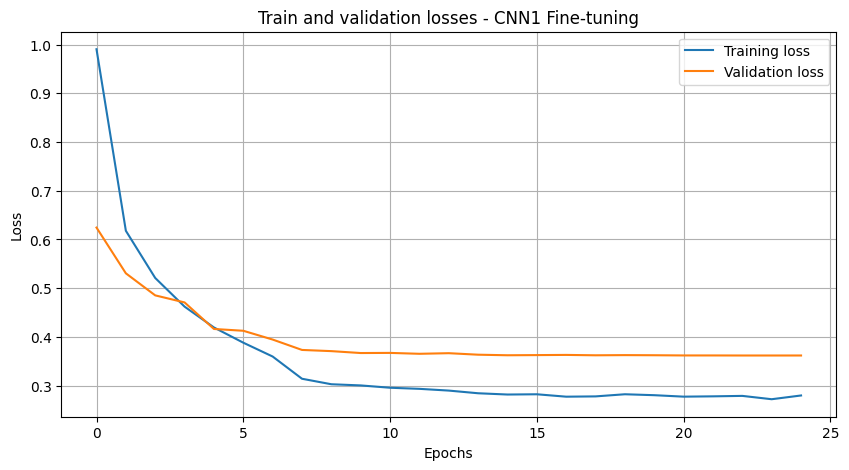

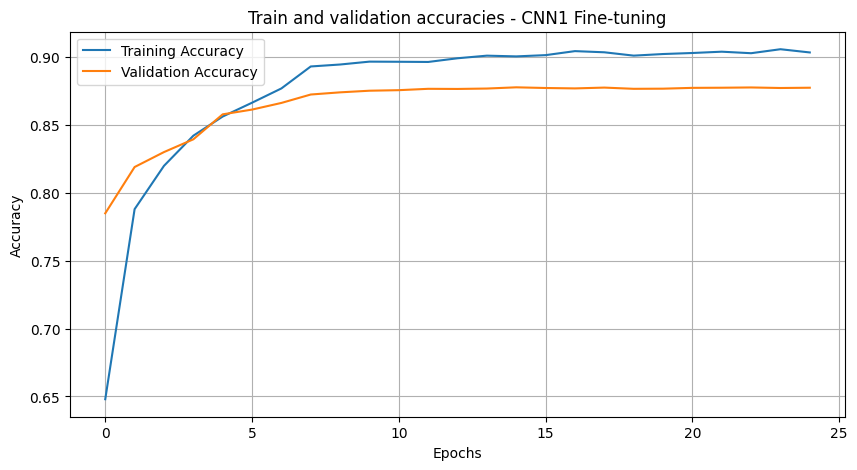

In [17]:
# 2. CNN1 Fine-tuning
model_vgg_finetune = models.vgg16(pretrained=True)
model_vgg_finetune.classifier[6] = nn.Linear(model_vgg_finetune.classifier[6].in_features, 10)
model_vgg_finetune = model_vgg_finetune.to(device)

optimizer_vgg_finetune = optim.SGD(model_vgg_finetune.parameters(), lr=0.001, momentum=0.9)
scheduler_vgg_finetune = lr_scheduler.StepLR(optimizer_vgg_finetune, step_size=7, gamma=0.1)

model_vgg_finetune, time_vgg_finetune_train, epochs_vgg_finetune, train_loss_vgg_finetune, val_loss_vgg_finetune, accuracy_total_train_vgg_finetune, accuracy_total_val_vgg_finetune = train_model(model_vgg_finetune, criterion, optimizer_vgg_finetune, scheduler_vgg_finetune, num_epochs=25)
accuracy_vgg_finetune, time_vgg_finetune_eval = evaluate_model(model_vgg_finetune)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_vgg_finetune, label='Training loss')
plt.plot(val_loss_vgg_finetune, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - CNN1 Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_vgg_finetune, label='Training Accuracy')
plt.plot(accuracy_total_val_vgg_finetune, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - CNN1 Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Epoch 0/24 Loss: 1.9480 Acc: 0.3128 Val Loss: 1.8283 Val Acc: 0.3689
Epoch 1/24 Loss: 1.7479 Acc: 0.3878 Val Loss: 1.7761 Val Acc: 0.3826
Epoch 2/24 Loss: 1.7119 Acc: 0.4025 Val Loss: 1.7424 Val Acc: 0.3955
Epoch 3/24 Loss: 1.6866 Acc: 0.4102 Val Loss: 1.7291 Val Acc: 0.4009
Epoch 4/24 Loss: 1.6813 Acc: 0.4129 Val Loss: 1.7173 Val Acc: 0.4058
Epoch 5/24 Loss: 1.6712 Acc: 0.4151 Val Loss: 1.7042 Val Acc: 0.4103
Epoch 6/24 Loss: 1.6685 Acc: 0.4174 Val Loss: 1.7050 Val Acc: 0.4103
Epoch 7/24 Loss: 1.6524 Acc: 0.4253 Val Loss: 1.6957 Val Acc: 0.4124
Epoch 8/24 Loss: 1.6487 Acc: 0.4244 Val Loss: 1.6901 Val Acc: 0.4151
Epoch 9/24 Loss: 1.6479 Acc: 0.4255 Val Loss: 1.6892 Val Acc: 0.4152
Epoch 10/24 Loss: 1.6433 Acc: 0.4269 Val Loss: 1.6895 Val Acc: 0.4163
Epoch 11/24 Loss: 1.6524 Acc: 0.4279 Val Loss: 1.6922 Val Acc: 0.4150
Epoch 12/24 Loss: 1.6439 Acc: 0.4287 Val Loss: 1.6885 Val Acc: 0.4162
Epoch 13/24 Loss: 1.6455 Acc: 0.4280 Val Loss: 1.6855 Val Acc: 0.4163
Epoch 14/24 Loss: 1.6399 Acc: 

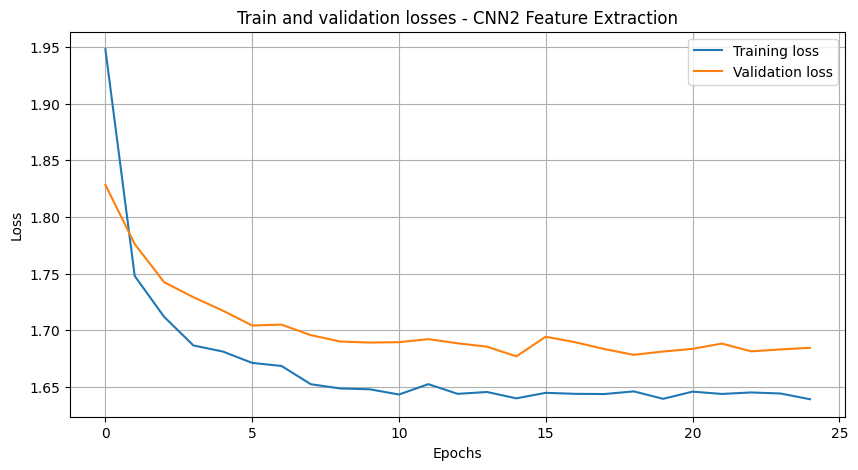

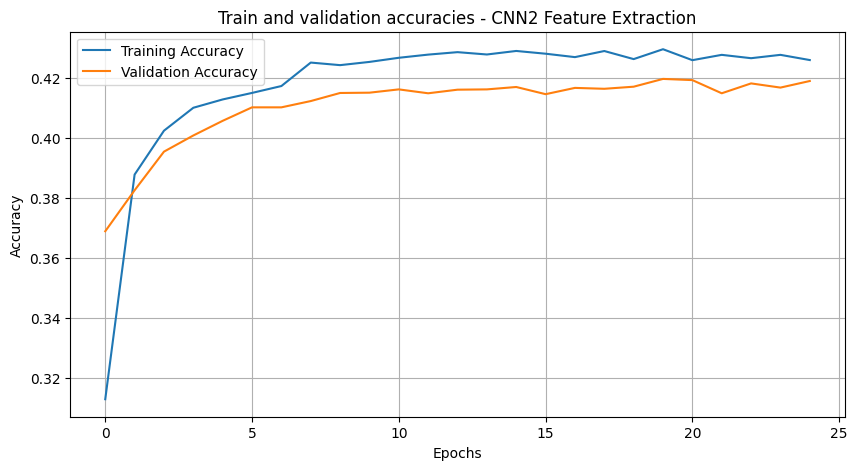

In [18]:
# 3. CNN2 Feature Extraction
model_resnet_feat = models.resnet18(pretrained=True)
for param in model_resnet_feat.parameters():
    param.requires_grad = False
num_ftrs = model_resnet_feat.fc.in_features
model_resnet_feat.fc = nn.Linear(num_ftrs, 10)
model_resnet_feat = model_resnet_feat.to(device)

optimizer_resnet_feat = optim.SGD(model_resnet_feat.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_resnet_feat = lr_scheduler.StepLR(optimizer_resnet_feat, step_size=7, gamma=0.1)

model_resnet_feat, time_resnet_feat_train, epochs_resnet_feat, train_loss_resnet_feat, val_loss_resnet_feat, accuracy_total_train_resnet_feat, accuracy_total_val_resnet_feat = train_model(model_resnet_feat, criterion, optimizer_resnet_feat, scheduler_resnet_feat, num_epochs=25)
accuracy_resnet_feat, time_resnet_feat_eval = evaluate_model(model_resnet_feat)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_resnet_feat, label='Training loss')
plt.plot(val_loss_resnet_feat, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - CNN2 Feature Extraction')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_resnet_feat, label='Training Accuracy')
plt.plot(accuracy_total_val_resnet_feat, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - CNN2 Feature Extraction')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

Epoch 0/24 Loss: 1.3143 Acc: 0.5353 Val Loss: 0.9449 Val Acc: 0.6637
Epoch 1/24 Loss: 0.8977 Acc: 0.6864 Val Loss: 0.7791 Val Acc: 0.7271
Epoch 2/24 Loss: 0.7758 Acc: 0.7289 Val Loss: 0.7045 Val Acc: 0.7547
Epoch 3/24 Loss: 0.7018 Acc: 0.7562 Val Loss: 0.6596 Val Acc: 0.7718
Epoch 4/24 Loss: 0.6393 Acc: 0.7762 Val Loss: 0.6282 Val Acc: 0.7838
Epoch 5/24 Loss: 0.5997 Acc: 0.7907 Val Loss: 0.5945 Val Acc: 0.7942
Epoch 6/24 Loss: 0.5667 Acc: 0.8023 Val Loss: 0.5788 Val Acc: 0.8010
Epoch 7/24 Loss: 0.5215 Acc: 0.8164 Val Loss: 0.5685 Val Acc: 0.8046
Epoch 8/24 Loss: 0.5108 Acc: 0.8205 Val Loss: 0.5622 Val Acc: 0.8079
Epoch 9/24 Loss: 0.5081 Acc: 0.8226 Val Loss: 0.5621 Val Acc: 0.8054
Epoch 10/24 Loss: 0.5032 Acc: 0.8211 Val Loss: 0.5585 Val Acc: 0.8069
Epoch 11/24 Loss: 0.4990 Acc: 0.8243 Val Loss: 0.5546 Val Acc: 0.8106
Epoch 12/24 Loss: 0.4970 Acc: 0.8260 Val Loss: 0.5530 Val Acc: 0.8091
Epoch 13/24 Loss: 0.4884 Acc: 0.8275 Val Loss: 0.5568 Val Acc: 0.8062
Epoch 14/24 Loss: 0.4840 Acc: 

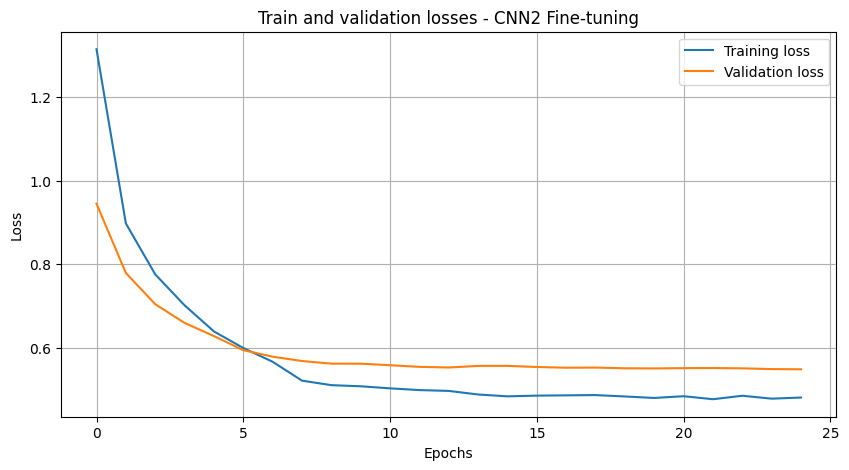

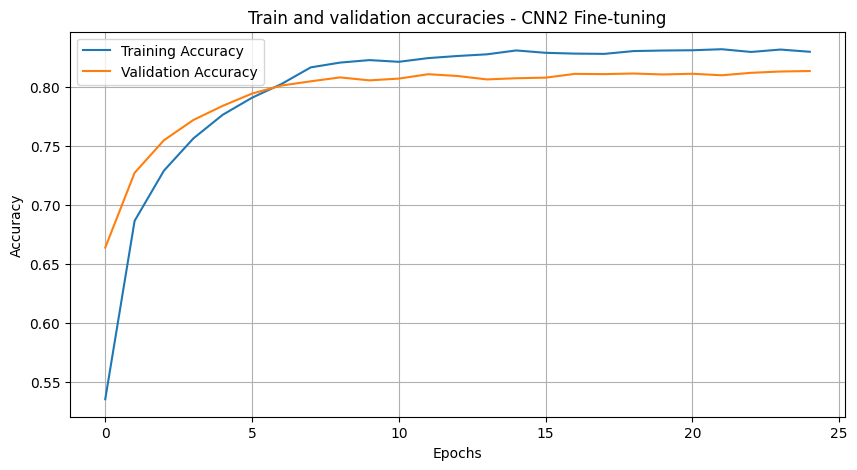

In [19]:
# 4. CNN2 Fine-tuning
model_resnet_finetune = models.resnet18(pretrained=True)
num_ftrs = model_resnet_finetune.fc.in_features
model_resnet_finetune.fc = nn.Linear(num_ftrs, 10)
model_resnet_finetune = model_resnet_finetune.to(device)

optimizer_resnet_finetune = optim.SGD(model_resnet_finetune.parameters(), lr=0.001, momentum=0.9)
scheduler_resnet_finetune = lr_scheduler.StepLR(optimizer_resnet_finetune, step_size=7, gamma=0.1)

model_resnet_finetune, time_resnet_finetune_train, epochs_resnet_finetune, train_loss_resnet_finetune, val_loss_resnet_finetune, accuracy_total_train_resnet_finetune, accuracy_total_val_resnet_finetune = train_model(model_resnet_finetune, criterion, optimizer_resnet_finetune, scheduler_resnet_finetune, num_epochs=25)
accuracy_resnet_finetune, time_resnet_finetune_eval = evaluate_model(model_resnet_finetune)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_resnet_finetune, label='Training loss')
plt.plot(val_loss_resnet_finetune, label='Validation loss')
plt.legend()
plt.grid()
plt.title('Train and validation losses - CNN2 Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_resnet_finetune, label='Training Accuracy')
plt.plot(accuracy_total_val_resnet_finetune, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Train and validation accuracies - CNN2 Fine-tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [20]:
# Tableau comparatif des résultats
data = {
    "Approach": ["From Scratch", "Feature Extraction", "Fine-tuning", "Feature Extraction", "Fine-tuning"],
    "Model": ["Scratch", "CNN1", "CNN1", "CNN2", "CNN2"],
    "Accuracy": [accuracy_scratch, accuracy_vgg_feat, accuracy_vgg_finetune, accuracy_resnet_feat, accuracy_resnet_finetune],
    "Training Time (s)": [time_scratch_train, time_vgg_feat_train, time_vgg_finetune_train, time_resnet_feat_train, time_resnet_finetune_train],
    "Epochs": [epochs_scratch, epochs_vgg_feat, epochs_vgg_finetune, epochs_resnet_feat, epochs_resnet_finetune]
}

df = pd.DataFrame(data)
print(df)

             Approach    Model  Accuracy  Training Time (s)  Epochs
0        From Scratch  Scratch     63.45         544.069170      25
1  Feature Extraction     CNN1     60.15         610.189403      25
2         Fine-tuning     CNN1     87.74        1006.507261      25
3  Feature Extraction     CNN2     41.91         574.400442      25
4         Fine-tuning     CNN2     81.33         670.944167      25
